In [1]:
import os
import tensorflow as tf
import json
import pandas as pd
import numpy as np
import random

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

c:\Users\antho\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [57]:
# Folders, named after the file label
labels = ["LEFT_ONE", "LEFT_TWO", "LEFT_THREE",
          "RIGHT_ONE", "RIGHT_TWO", "RIGHT_THREE"]

# Store the dataframes
dataframes = []

# Go through each label
for label in labels:
    # Go through each file in folder
    folder_path = os.listdir(label)

    for file_name in folder_path:
        # Read the file
        df = pd.read_parquet(f"{label}/{file_name}")
        df["sign"] = labels.index(label)
        dataframes.append(df)

    print(f"{label} has been processed!")




LEFT_ONE has been processed!
LEFT_TWO has been processed!
LEFT_THREE has been processed!
RIGHT_ONE has been processed!
RIGHT_TWO has been processed!
RIGHT_THREE has been processed!


In [58]:
dataframes[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, LeftX to RightY
Data columns (total 22 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       4 non-null      float64
 1   1       4 non-null      float64
 2   2       4 non-null      float64
 3   3       4 non-null      float64
 4   4       4 non-null      float64
 5   5       4 non-null      float64
 6   6       4 non-null      float64
 7   7       4 non-null      float64
 8   8       4 non-null      float64
 9   9       4 non-null      float64
 10  10      4 non-null      float64
 11  11      4 non-null      float64
 12  12      4 non-null      float64
 13  13      4 non-null      float64
 14  14      4 non-null      float64
 15  15      4 non-null      float64
 16  16      4 non-null      float64
 17  17      4 non-null      float64
 18  18      4 non-null      float64
 19  19      4 non-null      float64
 20  20      4 non-null      float64
 21  sign    4 non-null      int64  
dtypes:

In [81]:
dataframes[-1]

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,sign
LeftX,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,5
RightX,0.765625,0.723437,0.695312,0.725,0.771875,0.696875,0.660937,0.640625,0.623437,0.743750,...,0.732812,0.782813,0.792188,0.792188,0.79375,0.815625,0.803125,0.7875,0.778125,5
LeftY,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,5
RightY,0.783333,0.750000,0.685417,0.650,0.627083,0.564583,0.472917,0.410417,0.354167,0.552083,...,0.297917,0.570833,0.483333,0.416667,0.35000,0.612500,0.591667,0.6375,0.679167,5


In [84]:
# Define empty lists to store features and labels
features_list = []
labels_list = []

for dataframe in dataframes:
    # Extract features (all columns except the last one) and labels (last column)
    features = dataframe.iloc[:, :-1].values
    labels = dataframe["sign"].values

    features_list.append(features)
    labels_list.append(labels)

In [ ]:
labels_list

In [87]:
labels_list[-3000]

array([4, 4, 4, 4], dtype=int64)

In [62]:
# Step 1: Convert Dataframes to Tensors
data_tensors = []

for df in dataframes:
    # Extract features and labels from the dataframe
    features = df.iloc[:, :-1].values  # Exclude the last column as it's the label
    labels = df['sign'].values
    
    # Convert to NumPy arrays
    features_array = np.array(features)
    labels_array = np.array(labels)
    
    # Convert to TensorFlow tensors
    features_tensor = tf.convert_to_tensor(features_array, dtype=tf.float32)
    labels_tensor = tf.convert_to_tensor(labels_array, dtype=tf.int64)
    
    data_tensors.append((features_tensor, labels_tensor))

In [63]:
all_features = tf.concat([features_tensor for features_tensor, _ in data_tensors], axis=0)
all_labels = tf.concat([labels_tensor for _, labels_tensor in data_tensors], axis=0)

In [94]:
from sklearn.model_selection import train_test_split

all_features = all_features[:, np.newaxis, :]

# Assuming you have your data as TensorFlow tensors
features_train, features_val, labels_train, labels_val = train_test_split(
    all_features.numpy(), all_labels.numpy(), test_size=0.2, random_state=42)

In [104]:
# Step 4: Create an LSTM Model
model = tf.keras.Sequential()
model.add(Masking(mask_value=-2, input_shape=(1, 21)))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(6, activation='softmax'))

# Step 5: Compile the Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the Model
trained_model = model.fit(features_train, labels_train, epochs=100, validation_data=(features_val, labels_val), batch_size=16)

model.save("hand_model.h5")

Epoch 1/100
2891/2891 [==============================] - 19s 4ms/step - loss: 1.5588 - accuracy: 0.2985 - val_loss: 1.3396 - val_accuracy: 0.3834
Epoch 2/100
2891/2891 [==============================] - 11s 4ms/step - loss: 1.3259 - accuracy: 0.3790 - val_loss: 1.2112 - val_accuracy: 0.4387
Epoch 3/100
2891/2891 [==============================] - 11s 4ms/step - loss: 1.2305 - accuracy: 0.4264 - val_loss: 1.1475 - val_accuracy: 0.4715
Epoch 4/100
2891/2891 [==============================] - 13s 5ms/step - loss: 1.1827 - accuracy: 0.4485 - val_loss: 1.0936 - val_accuracy: 0.5272
Epoch 5/100
2891/2891 [==============================] - 14s 5ms/step - loss: 1.1542 - accuracy: 0.4639 - val_loss: 1.0863 - val_accuracy: 0.5005
Epoch 6/100
2891/2891 [==============================] - 13s 4ms/step - loss: 1.1330 - accuracy: 0.4739 - val_loss: 1.0639 - val_accuracy: 0.5104
Epoch 7/100
2891/2891 [==============================] - 13s 4ms/step - loss: 1.1224 - accuracy: 0.4783 - val_loss: 1.0488 -

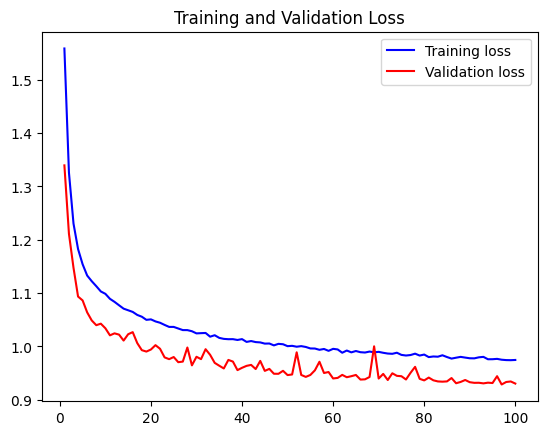

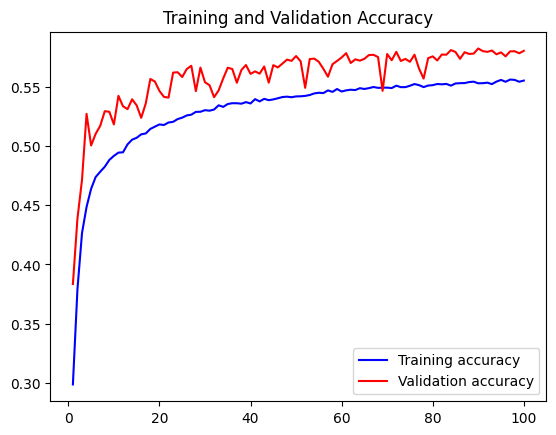

In [105]:
import matplotlib.pyplot as plt

# Assuming 'history' is your training history
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
accuracy = trained_model.history['accuracy']
val_accuracy = trained_model.history['val_accuracy']

epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()